# INIT PART #
This part is just for connecting to hopsworks and downloading the dependicies needed. 

We are adding the local dir for storing things aswell. 

In [82]:
import sys
from pathlib import Path
import os

root_dir = Path.cwd().parent   # ← one directory up
root_dir = str(root_dir)
print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")


Local environment
Added the following directory to the PYTHONPATH: /Users/annastegaras/Desktop/ID2223/project/ML_Scale_Project


In [83]:
import hopsworks
project = hopsworks.login()
fs = project.get_feature_store() 

2026-01-11 15:13:24,863 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-11 15:13:24,870 INFO: Initializing external client
2026-01-11 15:13:24,870 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-11 15:13:26,532 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286325


In [84]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score





# CREATING THE FEATURE VIEW #
The following part loads our three feature groups and the joins them in the feature view "stockholm_merged_fv", where total-landings will be the target label. All groups include date which will be used when joining so each column in each row correspond to the intended date. 





In [85]:
# Retrieve feature groups
flight_arlanda_fg = fs.get_feature_group(
    name='flight_data_arlanda',
    version=1,
)

weather_cal_fg = fs.get_feature_group(
    name='stockholm_weather_calendar_features',
    version=1,
)

In [86]:
flight_arlanda_fg.schema
weather_cal_fg.schema

[Feature('date', 'timestamp', None, True, False, False, None, None, 1893957),
 Feature('day_of_week', 'bigint', None, False, False, False, None, None, 1893957),
 Feature('is_weekend', 'bigint', None, False, False, False, None, None, 1893957),
 Feature('week_of_year', 'bigint', None, False, False, False, None, None, 1893957),
 Feature('month', 'bigint', None, False, False, False, None, None, 1893957),
 Feature('is_holiday', 'bigint', None, False, False, False, None, None, 1893957),
 Feature('tavg', 'double', None, False, False, False, None, None, 1893957),
 Feature('prcp', 'double', None, False, False, False, None, None, 1893957),
 Feature('snow', 'double', None, False, False, False, None, None, 1893957),
 Feature('wspd', 'double', None, False, False, False, None, None, 1893957)]

In [87]:
# Select features for training data.
selected_features_naive = (
    flight_arlanda_fg
        .select(['date','total_landings'])
        .join(weather_cal_fg.select_features(), on=['date'])
)

feature_view = fs.get_or_create_feature_view(
    name="flight_weather_cal_fv",
    version=1,
    description="Using weather and calendar data to predict flights",
    labels=["total_landings"],
    query=selected_features_naive,
)


2026-01-11 15:13:36,513 INFO: Using ['day_of_week', 'is_weekend', 'week_of_year', 'month', 'is_holiday', 'tavg', 'prcp', 'snow', 'wspd'] from feature group `stockholm_weather_calendar_features` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286325/fs/1265794/fv/flight_weather_cal_fv/version/1






# RETRIEVING THE TRAINING DATA IN "RAW" FORMAT #
In this section we use train_test_split() from Hopsworks to split the data, and then we do a sanity check with just wrighting X_train to see that the data we have retrived is correct. 





In [115]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start="2024-12-20",
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.83s) 
2026-01-11 15:19:17,555 WARNING: VersionWarning: Incremented version to `3`.

2026-01-11 15:19:17,557 INFO: Provenance cached data - overwriting last accessed/created training dataset from 2 to 3.


In [116]:
X_train

,date,day_of_week,is_weekend,week_of_year,month,is_holiday,tavg,prcp,snow,wspd
0,2020-02-17 00:00:00+00:00,0,0,8,2,0,5.6,0.2,0.0,35.3
1,2020-03-15 00:00:00+00:00,6,1,11,3,1,3.0,0.2,0.0,27.9
2,2020-04-06 00:00:00+00:00,0,0,15,4,0,7.7,0.0,0.0,20.7
3,2020-04-10 00:00:00+00:00,4,0,15,4,1,4.1,0.0,0.0,17.0
4,2020-04-15 00:00:00+00:00,2,0,16,4,0,8.4,1.5,0.0,24.0
...,...,...,...,...,...,...,...,...,...,...
2150,2024-11-08 00:00:00+00:00,4,0,45,11,0,4.2,0.0,0.0,14.3
2151,2024-11-13 00:00:00+00:00,2,0,46,11,0,3.1,0.0,0.0,18.1
2152,2024-11-15 00:00:00+00:00,4,0,46,11,0,5.3,0.1,0.0,25.7
2153,2024-11-25 00:00:00+00:00,0,0,48,11,0,8.5,3.6,0.0,30.7


In [117]:
y_train

,total_landings
0,273
1,209
2,32
3,12
4,33
...,...
2150,144
2151,231
2152,142
2153,209






# DATA CLEANING AND FEATURE ENGINEERING 
In this section we will remove NAN values, we will also insert some new features based on the raw data.
For example some dates are missing from opensky backfill and we need to remove all nan values for respective Xtrain and Ytrain, and the same for Xtest and ytest. 

In [118]:
# 3. Sanity check to see that both X_train and y_train has the same amount of rows 
print(X_train.info())
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1813 entries, 0 to 2154
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1813 non-null   object 
 1   day_of_week   1813 non-null   int64  
 2   is_weekend    1813 non-null   int64  
 3   week_of_year  1813 non-null   int64  
 4   month         1813 non-null   int64  
 5   is_holiday    1813 non-null   int64  
 6   tavg          1813 non-null   float64
 7   prcp          1813 non-null   float64
 8   snow          1813 non-null   float64
 9   wspd          1813 non-null   float64
dtypes: float64(4), int64(5), object(1)
memory usage: 155.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1813 entries, 0 to 2154
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   total_landings  1813 non-null   int64
dtypes: int64(1)
memory usage: 28.3 KB
None


In [119]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

# MODELING 

In [120]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [121]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

2026-01-11 15:19:26,495 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-11 15:19:26,496 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

MSE: 29942.164467195893
2026-01-11 15:19:26,498 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-11 15:19:26,499 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

R squared: -11.482368581594212


In [122]:
df = y_test
df['predicted_landings'] = y_pred

In [123]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,total_landings,predicted_landings,date
239,159,144.886368,2024-12-20 00:00:00+00:00
2010,213,216.601181,2024-12-21 00:00:00+00:00
1212,198,247.658279,2024-12-22 00:00:00+00:00
1213,97,84.868004,2024-12-23 00:00:00+00:00
113,109,98.042854,2024-12-24 00:00:00+00:00


<module 'matplotlib.pyplot' from '/Users/annastegaras/miniconda3/envs/aq/lib/python3.11/site-packages/matplotlib/pyplot.py'>

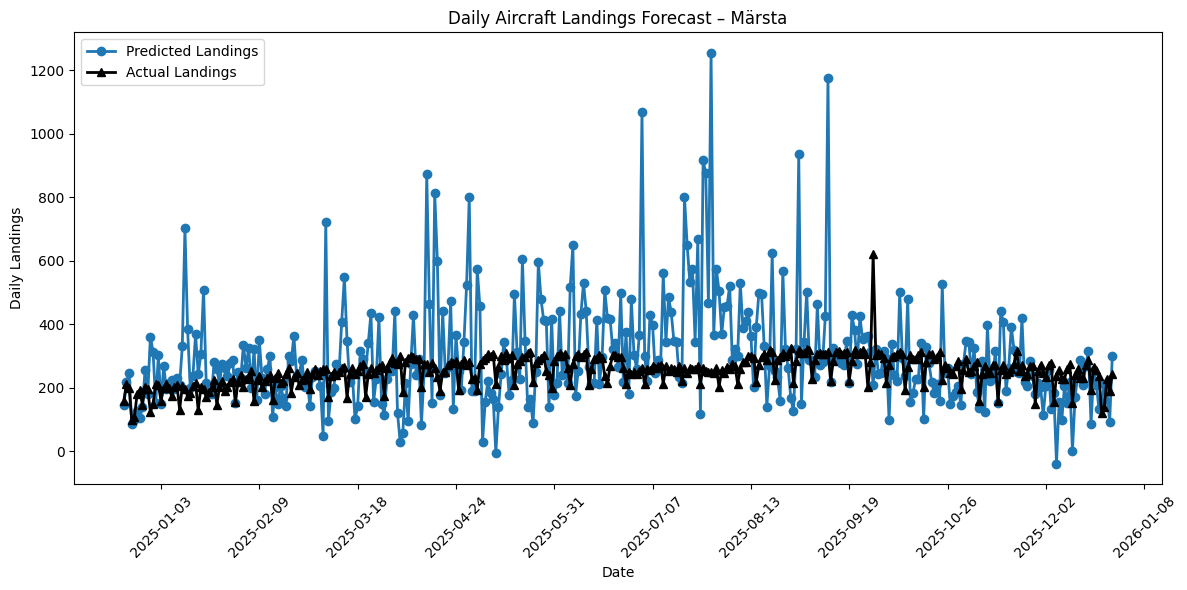

In [124]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import pandas as pd

def plot_landing_forecast(city: str,
                          df: pd.DataFrame,
                          file_path: str,
                          hindcast=False):

    fig, ax1 = plt.subplots(figsize=(12, 6))

    day = pd.to_datetime(df['date'])

    # ---- Main axis: landings ----
    ax1.plot(day, df['predicted_landings'],
             label='Predicted Landings',
             color='tab:blue', linewidth=2, marker='o')

    if hindcast:
        ax1.plot(day, df['total_landings'],
                 label='Actual Landings',
                 color='black', linewidth=2, marker='^')

    ax1.set_ylabel('Daily Landings')
    ax1.set_xlabel('Date')
    ax1.set_title(f"Daily Aircraft Landings Forecast – {city}")
    ax1.legend(loc='upper left')

    # ---- X-axis density control ----
    if len(df) > 12:
        ax1.xaxis.set_major_locator(MultipleLocator(len(df) // 10))

    plt.xticks(rotation=45)
    plt.tight_layout()
    return plt
    
plot_landing_forecast("Märsta", df, "flight_weather_model/images", hindcast=True) 

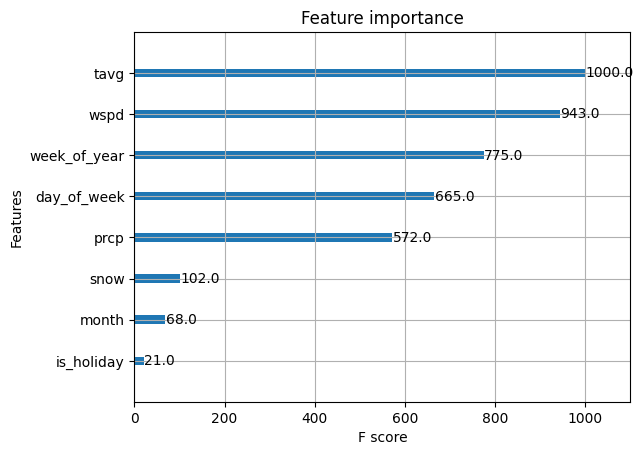

In [125]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
plt.show()

In [126]:
booster = xgb_regressor.get_booster()
score = booster.get_score(importance_type="gain")  # or "gain"
len(score), list(score.items())[:10]

(8,
 [('day_of_week', 20825.30859375),
  ('week_of_year', 31537.697265625),
  ('month', 44803.09375),
  ('is_holiday', 66583.0234375),
  ('tavg', 42601.4296875),
  ('prcp', 31957.744140625),
  ('snow', 33825.546875),
  ('wspd', 42170.91796875)])

In [127]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)


In [128]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [129]:
res_dict =  { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [130]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="flight_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Flight to Stockholm Predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/annastegaras/Desktop/ID2223/project/ML_Scale_Project/pipelines/model/model.json: 0.000%|     …

Uploading /Users/annastegaras/Desktop/ID2223/project/ML_Scale_Project/pipelines/model_schema.json: 0.000%|    …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286325/models/flight_xgboost_model/1


Model(name: 'flight_xgboost_model', version: 1)